In [27]:
!pip3 install tensorflow
!pip3 install tensorflow-gpu
!pip3 install opencv-python
!pip3 install matplotlib


[notice] A new release of pip available: 22.3.1 -> 24.1.2
[notice] To update, run: pip3 install --upgrade pip
  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [18 lines of output]
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "/private/var/folders/1v/1ywp4xjx1y116392trcjdvd00000gn/T/pip-install-9p327gpc/tensorflow-gpu_948ad5716b3d442ea6956a5df5b6b18d/setup.py", line 37, in <module>
          raise Exception(TF_REMOVAL_WARNING)
      Exception:
      
      The "tensorflow-gpu" package has been removed!
      
      Please install "tensorflow" instead.
      
      Other than the name, the two packages have been identical
      since TensorFlow 2.1, or roughly since Sep 2019. For more
      information, see: p

In [2]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [3]:
plt.imshow??

Signature:
plt.imshow(
    X,
    cmap=None,
    norm=None,
    *,
    aspect=None,
    interpolation=None,
    alpha=None,
    vmin=None,
    vmax=None,
    origin=None,
    extent=None,
    interpolation_stage=None,
    filternorm=True,
    filterrad=4.0,
    resample=None,
    url=None,
    data=None,
    **kwargs,
)
Docstring:
Display data as an image, i.e., on a 2D regular raster.

The input may either be actual RGB(A) data, or 2D scalar data, which
will be rendered as a pseudocolor image. For displaying a grayscale
image set up the colormapping using the parameters
``cmap='gray', vmin=0, vmax=255``.

The number of pixels used to render an image is set by the Axes size
and the *dpi* of the figure. This can lead to aliasing artifacts when
the image is resampled because the displayed image size will usually
not match the size of *X* (see
:doc:`/gallery/images_contours_and_fields/image_antialiasing`).
The resampling can be controlled via the *interpolation* parameter
and/or :rc:`imag

In [4]:
#import tensorflow dependencies - functional API
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf
 

In [6]:
#setup gpu
#limit how much vram can use avoid OOM errors by setting memory consumption growth
gpus = tf.config.experimental.list_physical_devices("gpu")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [7]:
for gpu in gpus:
    print(gpu)

In [5]:
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [5]:
POS_PATH

'data/positive'

In [10]:
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

FileExistsError: [Errno 17] File exists: 'data/positive'

In [1]:
#uncompress the tar file of faces in the wild dataset

!tar -xf lfw.tgz

In [12]:
#put our pics in the right folder
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH =  os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

In [34]:
#import uuid library to give unique names to each of our images collected
import uuid

collect images


In [37]:
# '{}.jpg'.format(uuid.uuid1())#test!

'18b7a1a8-4393-11ef-90ac-5a61087f7887.jpg'

In [38]:
#set up connection to webcam
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()

    #slice x, y, and color channel axis to create 250x250 pixel image
    frame = frame[350:350+250,950:950+250, :]

    #collect anchors
    if cv2.waitKey(1) & 0XFF == ord('a'):
        #create unique file path
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        #write out anchor image
        cv2.imwrite(imgname, frame)

    #collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)
        
    #show image back to screen
    cv2.imshow('Image Collection', frame)
    #Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()



In [ ]:
cv2.waitKey??

Docstring:
waitKey([, delay]) -> retval
.   @brief Waits for a pressed key.
.   
.   The function waitKey waits for a key event infinitely (when \f$\texttt{delay}\leq 0\f$ ) or for delay
.   milliseconds, when it is positive. Since the OS has a minimum time between switching threads, the
.   function will not wait exactly delay ms, it will wait at least delay ms, depending on what else is
.   running on your computer at that time. It returns the code of the pressed key or -1 if no key was
.   pressed before the specified time had elapsed. To check for a key press but not wait for it, use
.   #pollKey.
.   
.   @note The functions #waitKey and #pollKey are the only methods in HighGUI that can fetch and handle
.   GUI events, so one of them needs to be called periodically for normal event processing unless
.   HighGUI is used within an environment that takes care of event processing.
.   
.   @note The function only works if there is at least one HighGUI window created and the window is


: 

load and preprocess images


In [6]:
#use *wildcard to grab all files in anc_path with jpg file type. can use this with any file type compatible with tf
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(300)

In [7]:
dir_test = anchor.as_numpy_iterator()

In [8]:
#see what it does
dir_test.next()

b'data/anchor/dc61c9ee-4393-11ef-90ac-5a61087f7887.jpg'

scale and resize    

In [9]:
def preprocess(file_path):
    #read in image from file path and assign to new variable
    byte_img = tf.io.read_file(file_path)
    #load in image and decode jpeg
    img = tf.io.decode_jpeg(byte_img)
    #preprocessing steps - resize image to 100, 100 pixels, 3 channels
    img = tf.image.resize(img, (100,100))
    #scale image to be between 0 and 1... this takes every pixel value from original of 0-255 and makes it 0-1
    img = img / 255.0
    return img

In [10]:
img = preprocess("data/anchor/d9702762-4393-11ef-90ac-5a61087f7887.jpg")

In [11]:
img.numpy().min(), img.numpy().max()

(0.024019608, 0.8507353)

In [ ]:
plt.imshow(img)

Create labeled dataset


In [13]:
#we want to create positive and negative examples
#anchor and positive = 1
#anchor and negative = 0

positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [14]:
samples = data.as_numpy_iterator()

In [15]:
# look at a single sample 
example = samples.next()

build train and test partition

In [16]:
def preprocess_twin(input_img, val_img, label):
    return(preprocess(input_img), preprocess(val_img), label)

In [17]:
res = preprocess_twin(*example)

In [ ]:
len(res)
plt.imshow(res[1])

In [19]:
res[2]

1.0

In [20]:
#dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [21]:
samples = data.as_numpy_iterator()

In [22]:
len(samples.next())

3

In [23]:
samp = samples.next()

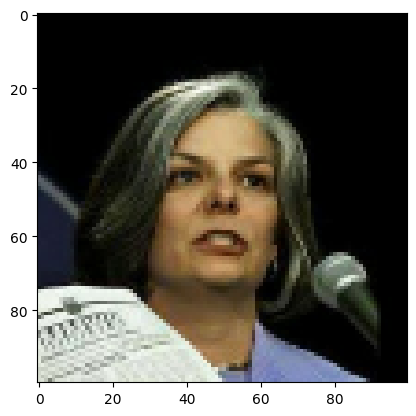

In [24]:
plt.imshow(samp[1])

In [25]:
samp[2]

0.0

In [26]:
round(len(data))

600

In [136]:
#train test split
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [150]:
#test partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [139]:
len(test_data)

180

In [140]:
len(train_data)

27

## BUILD our siamese NN

### Build our embedding layer

In [48]:
def make_embedding():
    inp = Input(shape=(100,100,3)) #100 X 100 pixels, 3 color channels

    #convolution takes the number of filters we want to pass through, sometimes we would specify stride, which tells how many pixels to traverse
    #at a time.
    c1 = Conv2D(64, (10,10), activation='relu')(inp) #64 filters, shape 10 x 10 pixels, relu activation, passing input to the layer
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1) #we take max value from 2x2 area

    #second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

    #third block
    c3 = Conv2D(128, (4,4), activation = 'relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

    #final feature block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4) #take 3 dimension convolution layer and flatten into a single dimension
    d1 = Dense(4096, activation = 'sigmoid')(f1)



    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [49]:
embedding  = make_embedding()

In [50]:
embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 91, 91, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 40, 40, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 17, 17, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

### Build L1 Siamese distance layer.. will tell us how similar our images are.

In [57]:
#l1 distance class
class L1Dist(Layer):
    #this creates a custom neural network layer. We have defined so when we export model, we can bring this layer along with us.
    def __init__(self, **kwargs):
        super().__init__() #inherit methods from Layer class from Keras
    
    def call(self, input_embedding, validation_embedding): #our two photos' embeddings are brought together here.
        input_embedding = tf.convert_to_tensor(input_embedding)
        validation_embedding = tf.convert_to_tensor(validation_embedding)
        input_embedding = tf.squeeze(input_embedding, axis=0) #remove potential first dimension
        validation_embedding = tf.squeeze(validation_embedding, axis=0)
        return tf.math.abs(input_embedding - validation_embedding) #return absolute value of the difference between our two photos' embeddings.

In [44]:
l1 = L1Dist()

### Bring everything together in our model

In [53]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [54]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [58]:
siamese_layer = L1Dist()

In [59]:
siamese_layer(inp_embedding,val_embedding)

<KerasTensor shape=(None, 4096), dtype=float32, sparse=False, name=keras_tensor_32>

In [107]:
def make_siamese_model():

    #handle inputs
    #anchor img in network
    input_image = Input(name='input_img', shape = (100,100,3))
    #validation img in network
    validation_image = Input(name='validation_img', shape=(100,100,3))

    #combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))

    #classification layer
    classifier = Dense(1, activation = 'sigmoid')(distances)

    return Model(inputs=[input_image, validation_image], outputs=classifier, name = 'SiameseNetwork')



In [108]:
SiameseNetwork = make_siamese_model()

In [ ]:
SiameseNetwork.summary()

### Training!

In [110]:
#create a loss function
binary_cross_loss = tf.losses.BinaryCrossentropy() #you can pass from_logits = True if your inputs to loss function aren't normalized.
#set up our optimizer for back prop
opt = tf.keras.optimizers.Adam(1e-4) #0.0001

In [111]:
#checkpoints
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=SiameseNetwork)

build the custom training step

In [141]:
test_batch = train_data.as_numpy_iterator()
batch_1 = test_batch.next()

In [142]:
len(batch_1[0]) #16 images in first part of batch

16

In [143]:
len(batch_1[1]) #16 images in positive/negative image array

16

In [144]:
len(batch_1[2]) #16 scalars either 0 or 1

16

In [145]:
X = batch_1[:2]
y = batch_1[2]

In [117]:
np.array(X).shape #2 arrays of 16 images each

(2, 16, 100, 100, 3)

In [118]:
@tf.function
def train_step(batch):
    with tf.GradientTape() as tape: #lets us capture our NN gradients for differentiation
        #get anchor and positive/negative image
        X = batch[:2] #grab our two image arrays
        #get label
        y = batch[2]

        #forward pass
        yhat = SiameseNetwork(X, training=True)

        #loss
        loss = binary_cross_loss(y, yhat)
    
    #gradients
    grad = tape.gradient(loss, SiameseNetwork.trainable_variables)

    #calculate updated weights and apply to network
    opt.apply_gradients(zip(grad, SiameseNetwork.trainable_variables))
    
    return loss

create our training loop

In [119]:
def train(data, EPOCHS):
    #loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        total_loss = 0

        #loop trhough each batch
        for idx, batch in enumerate(data):
            #run train step here and capture loss
            loss = train_step(batch)
            total_loss += loss
            #update progress bar with current batch loss
            progbar.update(idx+1, values=[("loss", loss)])
        #calculate average loss for the epoch
        avg_loss = total_loss / len(data)
        print(f"Average loss for Epoch {epoch}: {avg_loss:.4f}")

        #save checkpoints
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

train our model!

In [120]:
EPOCHS = 50

In [121]:
train(train_data, EPOCHS)


 Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - loss: 0.1241
Average loss for Epoch 1: 0.1241

 Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - loss: 0.1256
Average loss for Epoch 2: 0.1256

 Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - loss: 0.0284
Average loss for Epoch 3: 0.0284

 Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - loss: 0.0120
Average loss for Epoch 4: 0.0120

 Epoch 5/50


2024-07-18 11:38:39.201852: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - loss: 0.0077
Average loss for Epoch 5: 0.0077

 Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - loss: 0.0059
Average loss for Epoch 6: 0.0059

 Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - loss: 0.0060
Average loss for Epoch 7: 0.0060

 Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - loss: 0.0031
Average loss for Epoch 8: 0.0031

 Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - loss: 0.0028
Average loss for Epoch 9: 0.0028

 Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - loss: 0.0023
Average loss for Epoch 10: 0.0023

 Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - loss: 0.0028
Average loss for Epoch 11: 0.0028

 Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - loss: 0.0019
Average loss for Epoch 12: 0.0019

 Epoch 13/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - loss: 0.0017
Average loss for Epoch 13: 0.0017

 Epoch 14/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - loss: 0.0017
Average loss for Epoch 14: 0.0017

 E

### Evaluate our model


In [151]:
#import evaluation metrics
from tensorflow.keras.metrics import Precision, Recall

In [161]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next() #converts tf tensor into numpy equivalent

In [153]:
test_input

array([[[[0.7732843 , 0.7615196 , 0.7026961 ],
         [0.7764706 , 0.7647059 , 0.7058824 ],
         [0.7764706 , 0.7647059 , 0.7058824 ],
         ...,
         [0.5264706 , 0.50686276, 0.48333332],
         [0.7264706 , 0.70686275, 0.68333334],
         [0.7382353 , 0.71862745, 0.69509804]],

        [[0.77254903, 0.7607843 , 0.7019608 ],
         [0.7747549 , 0.7639706 , 0.7051471 ],
         [0.7754902 , 0.7647059 , 0.7058824 ],
         ...,
         [0.5264706 , 0.50784314, 0.4715686 ],
         [0.6730392 , 0.6544118 , 0.61813724],
         [0.7267157 , 0.7080882 , 0.6718137 ]],

        [[0.77254903, 0.7607843 , 0.7019608 ],
         [0.76862746, 0.7607843 , 0.7019608 ],
         [0.76936275, 0.7615196 , 0.7026961 ],
         ...,
         [0.51666665, 0.48333332, 0.44705883],
         [0.55245095, 0.51911765, 0.48284313],
         [0.6781863 , 0.6507353 , 0.61151963]],

        ...,

        [[0.80784315, 0.7607843 , 0.69803923],
         [0.80759805, 0.76053923, 0.69779414]

In [154]:
# test_var = test_data.as_numpy_iterator().next()

In [162]:
#make predictions
y_hat = SiameseNetwork([test_input, test_val])
y_hat

<tf.Tensor: shape=(16, 1), dtype=float32, numpy=
array([[3.5901201e-07],
       [1.7525857e-05],
       [5.3031062e-08],
       [1.5703159e-07],
       [1.3008901e-05],
       [7.6733733e-07],
       [2.2431391e-06],
       [2.5058186e-04],
       [9.9909133e-01],
       [2.1700264e-07],
       [9.9826849e-01],
       [7.3225368e-05],
       [9.9983799e-01],
       [7.2779159e-07],
       [7.8571190e-08],
       [9.9998969e-01]], dtype=float32)>

In [163]:
#post process the results
[1 if prediction > .5 else 0 for prediction in y_hat]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1]

In [158]:
# #long way to do the above:
# res = []
# for prediction in y_hat:
#     if prediction > .5:
#         res.append(1)
#     else:
#         res.append(0)

In [164]:
#create a metric object
m = Recall()
#update the state, calculate the recall value
m.update_state(y_true, y_hat)
#return recall result
m.result().numpy()

1.0

In [ ]:
#visualize results
#plt size
plt.figure(figsize=(18,8))

#set first subplot - since we putting two plots side by side
plt.subplot(1,2,1)
plt.imshow(test_input[0])
#set second subplot
plt.subplot(1,2,2) #first row in the two columns, value in the second column. 
plt.imshow(test_val[0])

#render the plot
plt.show()


### Save our model

In [166]:
#save weights
SiameseNetwork.save('siamesemodel.h5')

In [167]:
#reload model
model = tf.keras.models.load_model('siamesemodel.h5',
                                   custom_objects={'L1Dist': L1Dist, 'BinaryCrossentropy': tf.losses.BinaryCrossentropy}) #need this custom objects to save our custom L1 layer.

#can also use tf.keras.models.load_weights()

In [168]:
#make prediction for testing reloaded model
model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step


array([[3.5901201e-07],
       [1.7525857e-05],
       [5.3031062e-08],
       [1.5703159e-07],
       [1.3008901e-05],
       [7.6733733e-07],
       [2.2431391e-06],
       [2.5058186e-04],
       [9.9909133e-01],
       [2.1700264e-07],
       [9.9826849e-01],
       [7.3225368e-05],
       [9.9983799e-01],
       [7.2779159e-07],
       [7.8571190e-08],
       [9.9998969e-01]], dtype=float32)

In [169]:
#reload model summary
model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_5 (L1Dist)  │ (None, 4096)      │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1)         │      4,097 │ l1_dist_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

### Real time testing

In [177]:
#verifica4tion function
def verify(model, det_thres, ver_thres):
    '''Detection threshold: metric above which a prediction is considered positive
    ver threshold: proportion of positive predictions/ total positive samples'''

    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))

        #make predictions
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis = 1)))
        results.append(result)


    #detection threshold
    detection = np.sum(np.array(results) > det_thres)

    #verification threshold
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images')))
    verified = verification > ver_thres

    return results, verified

In [178]:
cap = cv2.VideoCapture(1)
while cap.isOpened():
    ret, frame = cap.read()
    #slice x, y, and color channel axis to create 250x250 pixel image
    frame = frame[350:350+250,950:950+250, :]
    cv2.imshow('Verification', frame)

    #verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        #save input image
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        #run verification
        results, verified = verify(model, .5, .5)
        print(verified)

    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
True
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━

In [182]:
np.sum(np.squeeze(results) > .5)

0